# FateCompass robustness against underlying kNN

In this notebook we tested the robustness of FateCompass predictions in terms of fate probabilities and TF activity profiles against the underlying kNN. Here we used a network obtained using [Sanity](https://github.com/jmbreda/Sanity) (Breda, Zavolan, and van Nimwegen 2021).

For this test we used a dataset of endocrine development in the pancreas, which has four major final fates $\alpha$, $\beta$, $\delta$, and $\epsilon$. See [here](https://scvelo.readthedocs.io/scvelo.datasets.pancreas/) for more details.  

In [1]:
import pandas as pd
import numpy as np
import scanpy as sc
import scanpy.external as sce
import scvelo as scv
import cellrank as cr
import matplotlib.pyplot as plt

In [2]:
scv.settings.verbosity = 3
scv.settings.set_figure_params("scvelo")
cr.settings.verbosity = 2

%matplotlib inline

### Load data 

1. Annotated AnnData object. The data is already pre-processed and annotated with RNA velocity. 

In [3]:
adata = scv.read('../../fatecompass/data/Pancreas/endocrinogenesis_day15_velo.h5ad', cache=True)
adata

AnnData object with n_obs × n_vars = 3696 × 7018
    obs: 'clusters', 'S_score', 'G2M_score', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_counts', 'velocity_self_transition'
    var: 'highly_variable_genes', 'gene_count_corr', 'velocity_genes'
    uns: 'clusters_colors', 'day_colors', 'neighbors', 'pca', 'recover_dynamics', 'velocity_graph', 'velocity_graph_neg', 'velocity_params'
    obsm: 'X_pca', 'X_umap', 'velocity_umap'
    varm: 'loss'
    layers: 'Ms', 'Mu', 'fit_t', 'fit_tau', 'fit_tau_', 'spliced', 'unspliced', 'velocity', 'velocity_u'
    obsp: 'connectivities', 'distances'

2. Binding site matrix  

In [4]:
filename = '../../fatecompass/data/binding_sites/binding_sites_mouse.csv'
bs = pd.read_csv(filename, index_col=0, header=0,sep=';')
bs.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7018 entries, Mrpl15 to Ddx3y
Columns: 181 entries, Ahr to Zkscan3
dtypes: float64(181)
memory usage: 9.7+ MB


3. Predefined nearest neighbor graph computed using Sanity

In [5]:
filename = 'input/sanity_knn_matrix_sara.txt'
knn = pd.read_csv(filename,header=None,sep='\t')
knn.values 

array([[1779,  134, 1319, ..., 3172, 3540, 3139],
       [3116, 3337, 1986, ..., 1396,  466, 2307],
       [ 843, 1286, 1149, ..., 2952,  431,  631],
       ...,
       [2771, 3401,  493, ...,  868, 3621, 2593],
       [2173, 3135, 2791, ..., 1633, 3616,  743],
       [1412, 1269, 2088, ..., 2040, 1506, 2447]])

In [18]:
adata.obsm['indices_fatecompass'] = knn.values - np.ones([len(knn.values),10]) 
adata.obsm['indices_fatecompass'] = adata.obsm['indices_fatecompass'].astype(int)

### Robustness against underlying kNN

In [7]:
mode = 'velocity'
components = 10

# The Following are the parameters for which we're testing the robustness
n_neighbors = 10
basis = 'pca'

replicates = 1

# Selecting cells as examples
mycell_1 = np.flatnonzero(adata.obs['clusters'] == 'Beta')[10]
mycell_2 = np.flatnonzero(adata.obs['clusters'] == 'Pre-endocrine')[20]
mycell_3 = np.flatnonzero(adata.obs['clusters'] == 'Ngn3 low EP')[13]
mycells  = [mycell_1, mycell_2, mycell_3] 
    
# Formating data
fate_pbbs_pca = {c: {i: {r: 0 for r in range(replicates)} for i in mycells} for c in adata.obs['clusters'].cat.categories}

dimensions = sc.tl.pca(adata, copy= True)
scv.tl.velocity_embedding(dimensions, basis='pca')
velo_dimensions = dimensions.obsm['velocity_pca'][:,0:components]
dimensions = dimensions.obsm['X_pca'][:,0:components]

adata.obsm['dimensions_fatecompass'] = dimensions
adata.obsm['velo_dimensions_fatecompass'] = velo_dimensions

for r in range(replicates):
    # Building the graph NO NEED!
    #from fatecompass import graph_fatecompass
    #graph_fatecompass(adata, mode, basis, components, n_neighbors)

    # Stochastic simulations
    root = 335
    numsimcells = 1000
    # The following parameter might change depending on the n_neighbors. More connected graphs might need less iterations to converge.
    numiter = 250
    from fatecompass import rna_velocity_driven_stochastic_simulations 
    rna_velocity_driven_stochastic_simulations(adata, root=root, cell_types_key='clusters',
                                               numiter=numiter, 
                                               numsimcells=numsimcells,
                                               cutoff=0.05)
    adata.uns['num_trajectories']

    # Computing fate probabilities
    from fatecompass import fate_probabilities
    fate_probabilities(adata, cell_types_key='clusters')

    for c in adata.obs['clusters'].cat.categories:
        for i in mycells:
            fate_pbbs_pca[c][i][r] = adata.uns['fate_pbbs'][c][i,]

computing velocity embedding
    finished (0:00:03) --> added
    'velocity_pca', embedded velocity vectors (adata.obsm)

Fitted value of D:  [1.8885] 
Fitted value of dt:  23.509481606581573

*****Transition probabilities successfully computed.*****


*****Performing stochastic simulations.*****

sim cell	 0
sim cell	 100
sim cell	 200
sim cell	 300
sim cell	 400
sim cell	 500
sim cell	 600
sim cell	 700
sim cell	 800
sim cell	 900

Finished -->added
 'states' and 'num_trajectories', stochastic trajectories (adata.uns)



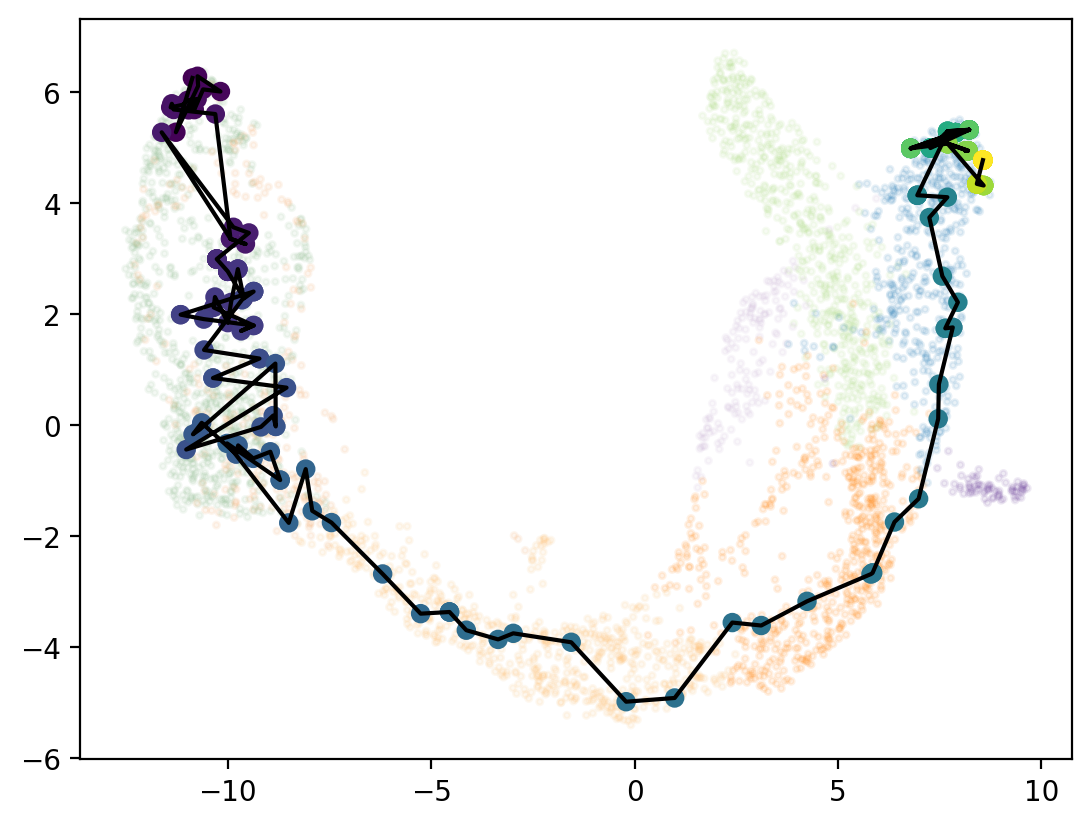

In [8]:
# plot example of simulated cell
from fatecompass import plot_sim_cell
mycell = adata.uns['states'][:,4]
plot_sim_cell(adata, 'umap', mycell, color = 'clusters')

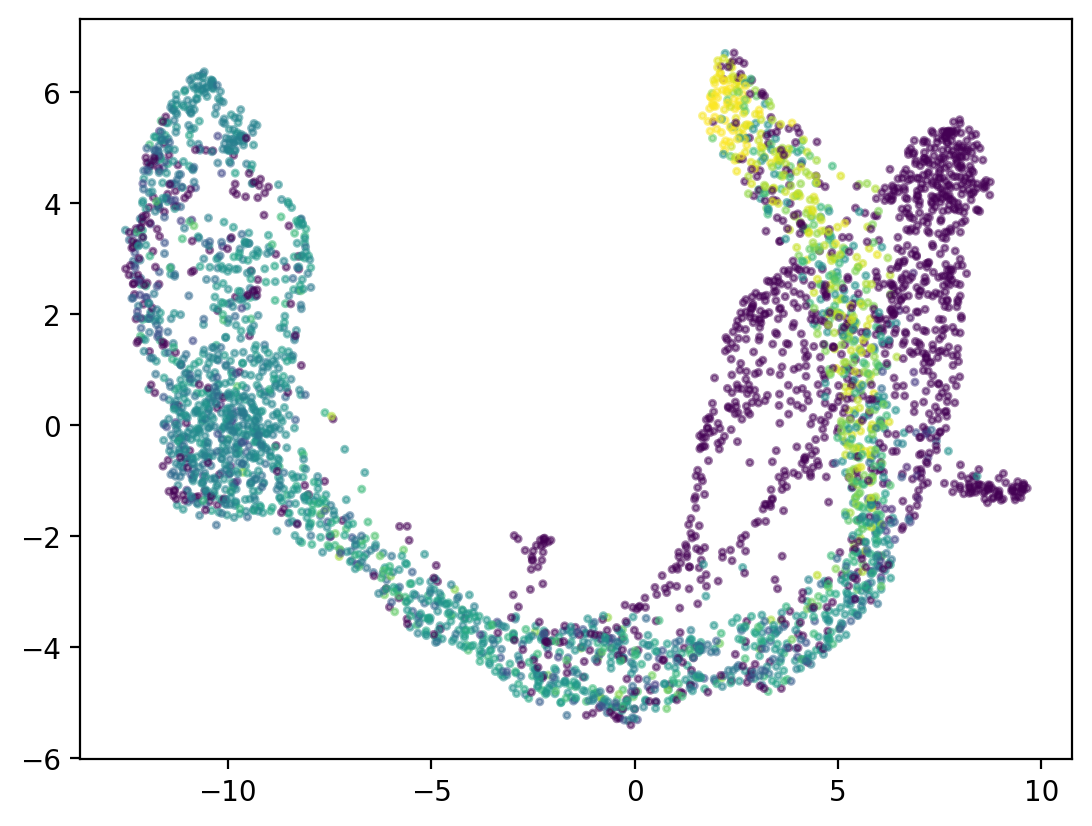

In [9]:
# Plot fate probabilities for a given final state
from fatecompass import plot_fate_pbb
plot_fate_pbb(adata, basis='umap', color='Beta')

Export data to compare 

In [10]:
adata.uns['num_trajectories']

{'Ductal': 49,
 'Ngn3 low EP': 20,
 'Ngn3 high EP': 52,
 'Pre-endocrine': 7,
 'Beta': 495,
 'Alpha': 275,
 'Delta': 0,
 'Epsilon': 102}

### Robustness against underlying kNN for TF activities

In [19]:
# Computing TF activities
from fatecompass import tf_activities
tf_activities(adata, bs, tolerance = 4.6e-3)

# Average profiles over stochastic trajectories
from fatecompass import avg_profiles_over_trajectories
avg_profiles_over_trajectories(adata, cell_types_key='clusters')

# Selecting a TF as gold standard to illustrate robustness
trajectory = 'Beta'
variable = 'Nkx6-1_Evx1_Hesx1'
map_tf_id = list(adata.uns['tf_activities_distribution'].keys())

# Getting dynamic behavior for the selected TF
x = np.linspace(0,1,(adata.uns['mean_A'][trajectory][10:,:]).shape[0])
y = (adata.uns['mean_A'][trajectory][:,map_tf_id.index(variable)][10:,]).toarray().reshape([len(x),])
error = (adata.uns['sem_A'][trajectory][:,map_tf_id.index(variable)][10:,]).toarray().reshape([len(x),])

Number of cells: 3696
Number of genes: 7018
Number of motifs: 181
Normalized binding site matrix [genes x motifs]: (7018, 181)
Cell- and Gene- Normalized expression matrix [cells x genes]: (3696, 7018)

Initializing cross-validation scheme to fit the value of t for data diffusion regularization

Diffusion time:  0 	 Residual:  0.01095193246681829
Diffusion time:  1 	 Residual:  0.01095193246681829
Diffusion time:  2 	 Residual:  0.007384446921780141
Diffusion time:  3 	 Residual:  0.005673066857290701
Diffusion time:  4 	 Residual:  0.00481359805223075

Initializing bootstrapping to build the distribution of the estimate for the TF activities.

sample	 0
sample	 10
sample	 20
sample	 30
sample	 40
sample	 50
sample	 60
sample	 70
sample	 80
sample	 90

Finished -->added
 'tf_activities' and 'tf_activities_distribution', TF activities regularized (adata.uns)

sim cell	 0
sim cell	 100
sim cell	 200
sim cell	 300
sim cell	 400
sim cell	 500
sim cell	 600
sim cell	 700
sim cell	 800
sim c

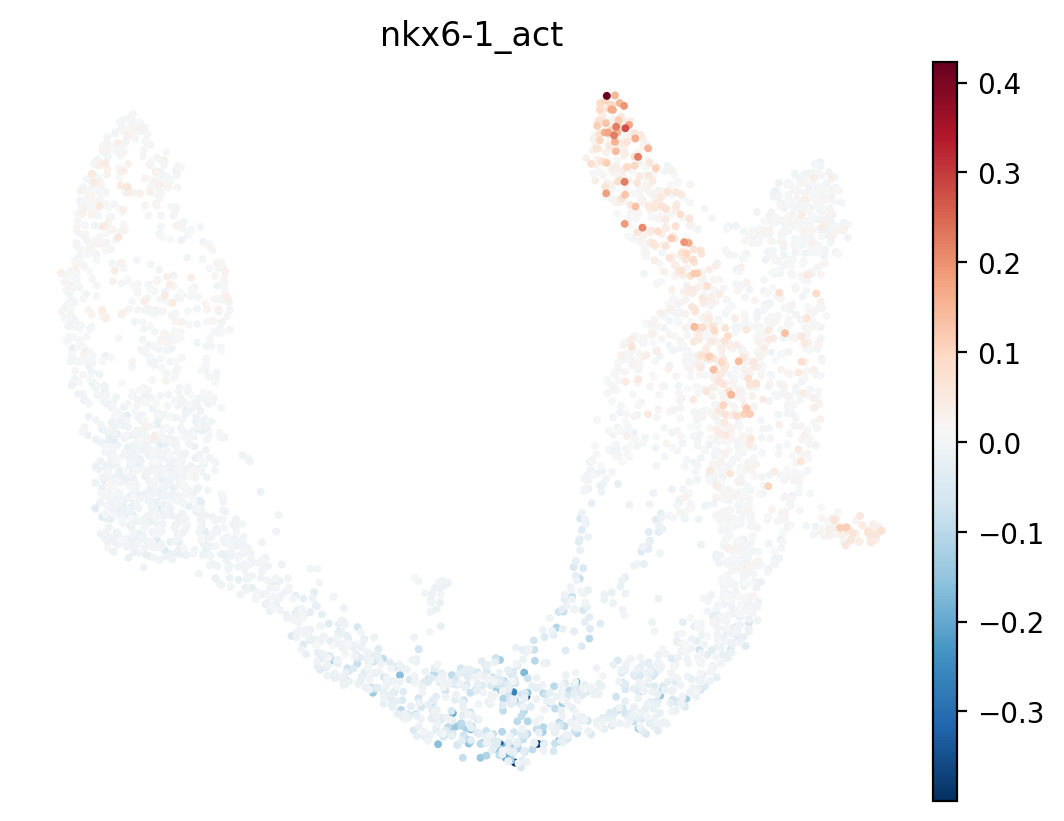

In [20]:
# plot activity of selected TF in umap embedding
adata.obs['nkx6-1_act'] = adata.uns['tf_activities'].loc[:,variable]
sc.pl.umap(adata, color=['nkx6-1_act'], frameon=False, cmap='RdBu_r')

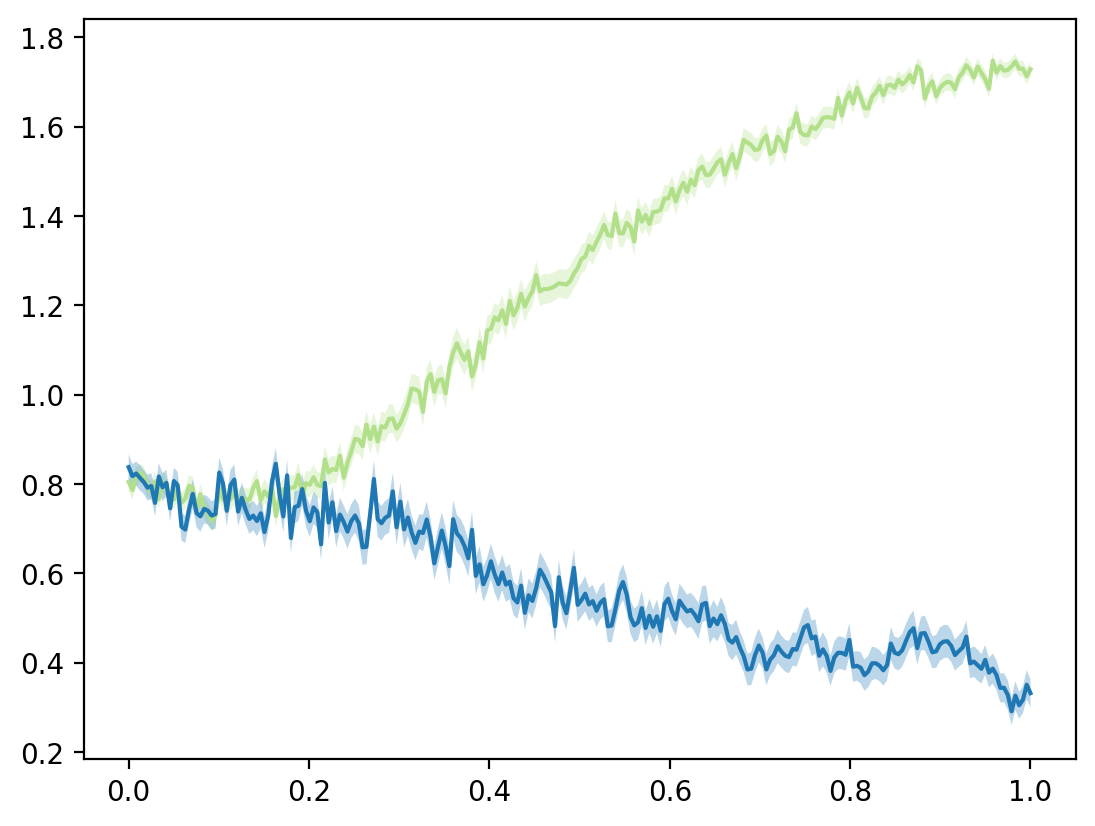

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


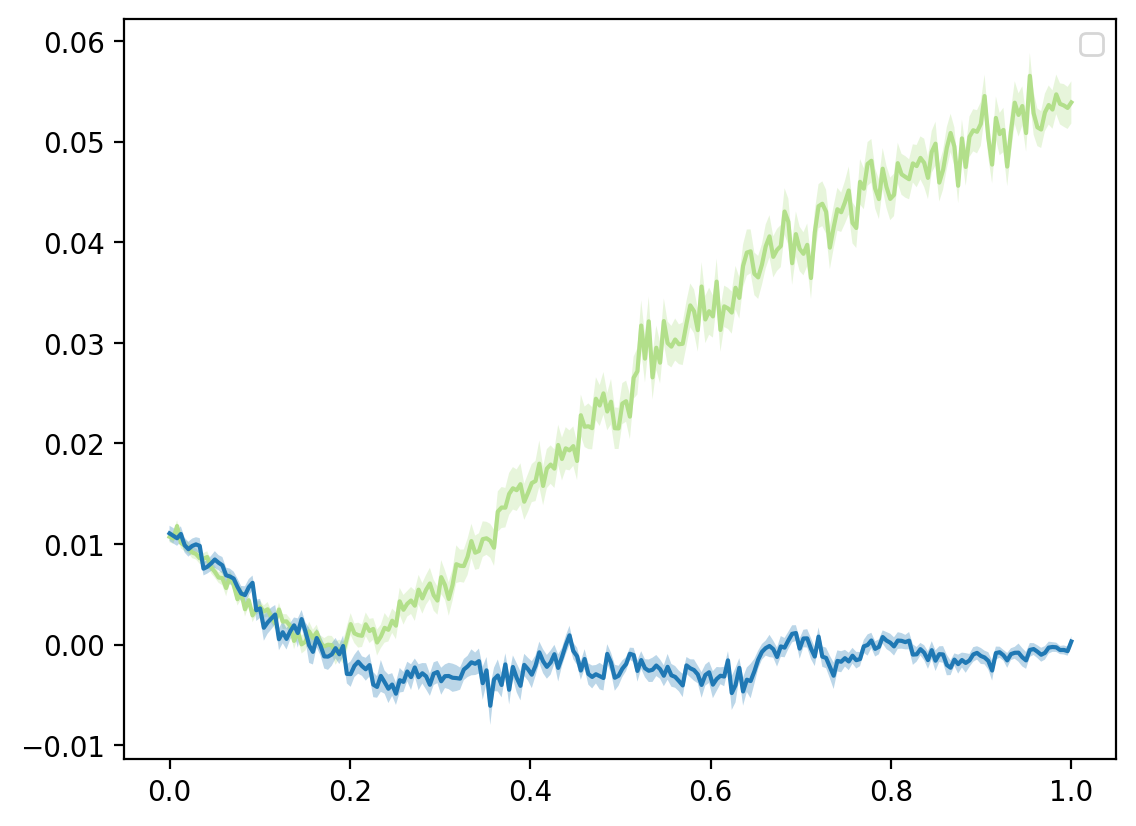

In [21]:
# plot expression and acttivity profiles of selected TF 
from fatecompass import plot_trajectory
plot_trajectory(adata, mode='mRNA' ,variable=['Nkx6-1'], 
                cell_types_key='clusters', trajectory=['Beta','Alpha'])
plot_trajectory(adata, mode='activity' ,variable=['Nkx6-1_Evx1_Hesx1'], 
                cell_types_key='clusters', trajectory=['Beta','Alpha'])

### Robustness against underlying kNN for Differential TF activity analysis


 z-score --> computed

variability over time --> computed

dynamical correlation --> computed



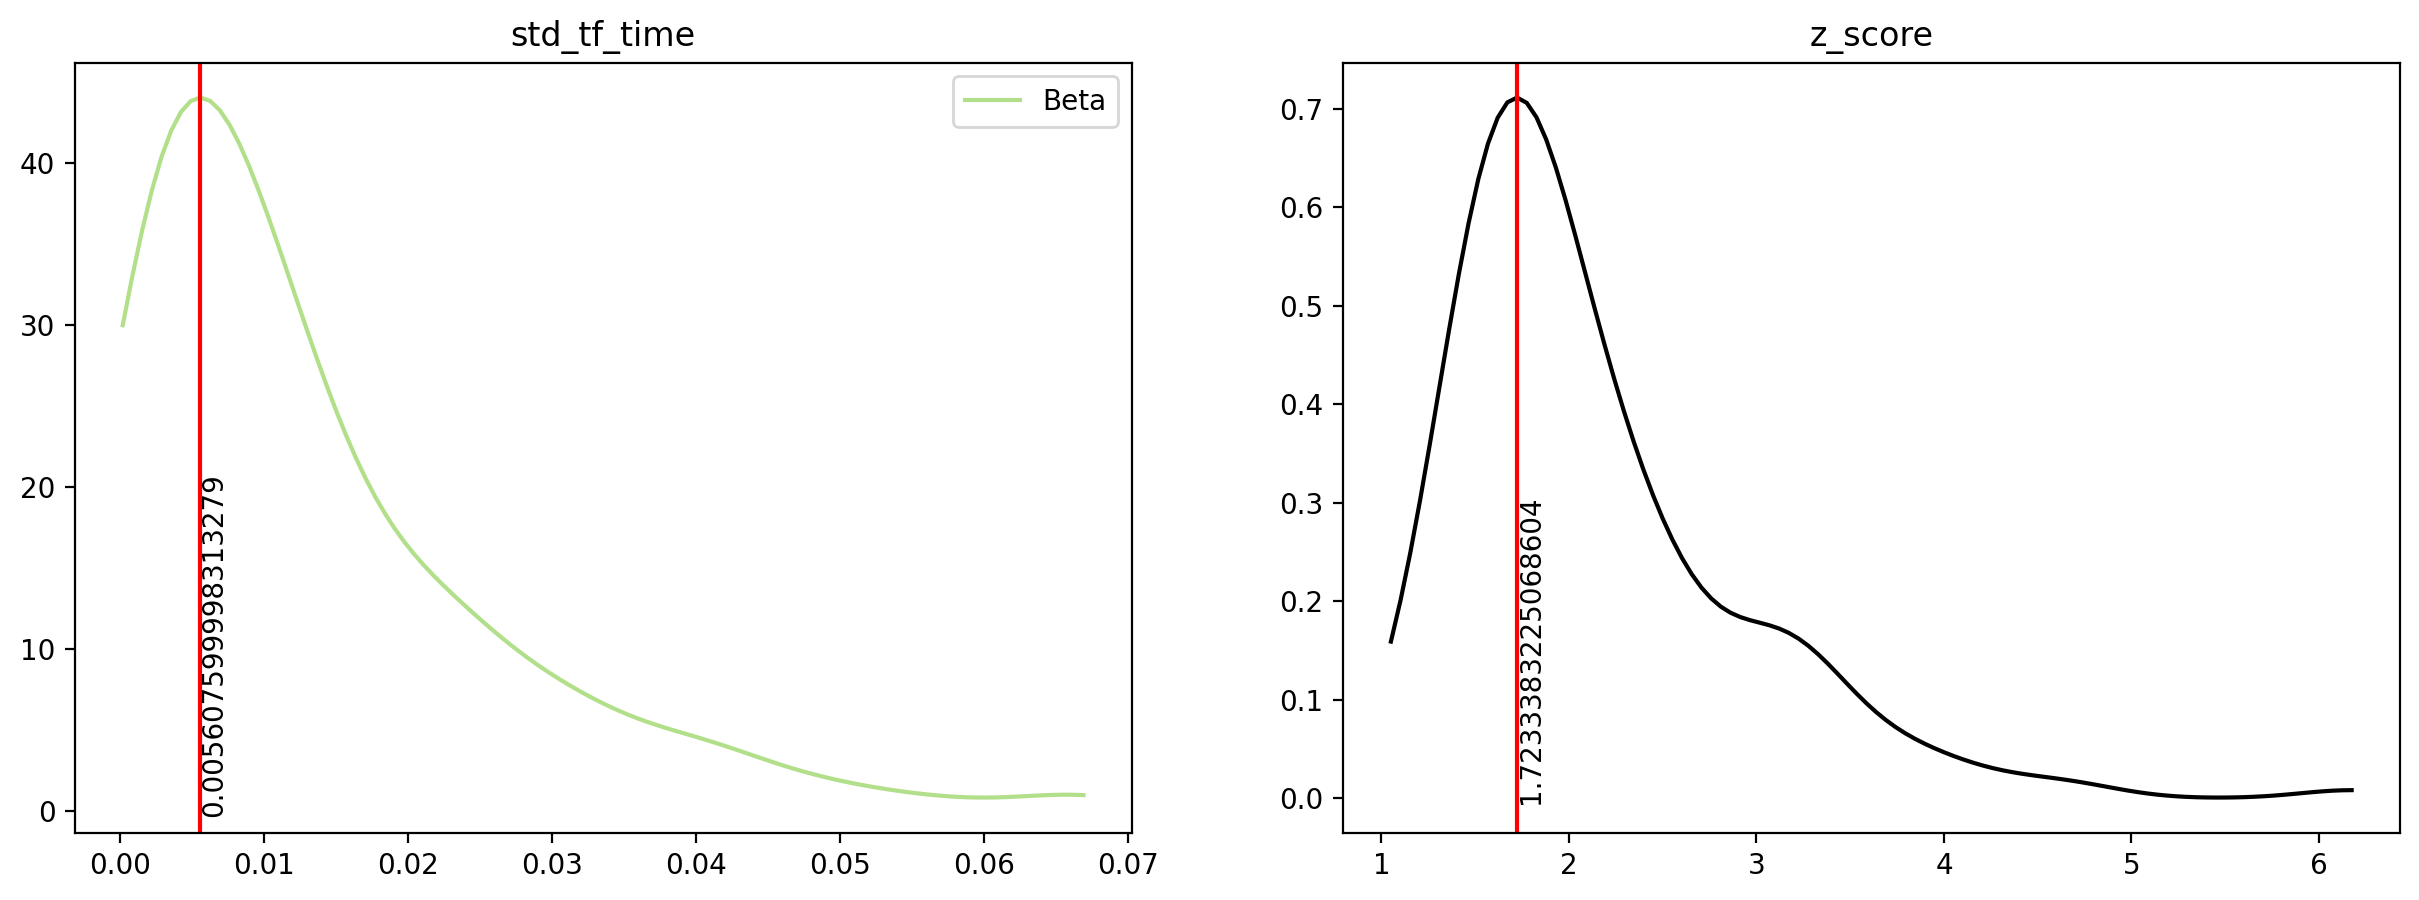

In [22]:
# Performing differential activity analysis
from fatecompass import differential_tf_activity
differential_tf_activity(adata, 'clusters')
# Get an idea for setting the thresholds for filtering
from fatecompass import ksdensity_fatecompass
ksdensity_fatecompass(adata, criterion=['std_tf_time','z_score'], cell_types_key='clusters', 
                      trajectory=['Beta'])

In [23]:
# Setting the thresholds for filtering
thresholds = {'variability': 0.005, 'z_score': 1.7, 'correlation': 0.5}
thresholds

{'variability': 0.005, 'z_score': 1.7, 'correlation': 0.5}

In [24]:
# Perform filtering to get lineage-specific TFs
from fatecompass import get_df_differential_tf_activity
df = get_df_differential_tf_activity(adata,fates=['Beta'], 
                                     thresholds=thresholds)
df

,TFs,std_tf_time_Beta,max_cross_corr_Beta,time_max_cross_corr_Beta,z_score,FateCompass_prediction
Ahr,Ahr,0.005767,0.964909,0,2.357176,Beta
Arid3a,Arid3a,0.004153,0.388782,122,1.879230,NaN
Arid5b,Arid5b,0.002115,0.302636,-206,1.361444,NaN
Arnt,Arnt,0.012875,0.374921,-168,1.342450,NaN
Arnt2,Arnt2,0.023599,0.697845,0,1.949401,Beta
...,...,...,...,...,...,...
Zfhx3,Zfhx3,0.020677,0.397512,-171,1.903242,NaN
Zfx_Mecp2,Zfx,0.001427,0.44109,-165,1.814884,NaN
Zfx_Mecp2,Mecp2,0.001427,0.773135,0,1.814884,NaN
Zkscan1,Zkscan1,0.010669,0.605726,-3,2.018206,Beta


Export data to compare 

In [25]:
df.to_csv('output/TF_act_analysis_sanity.txt', header=True, index=True, sep='\t')